In [52]:
%%javascript
// disable scroll
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
// from https://stackoverflow.com/questions/36757301/disable-ipython-notebook-autoscrolling

<IPython.core.display.Javascript object>

In [1]:
import simpy
from __future__ import division

## Simpy tutorial

### Generator statements

In [2]:
def range_(n):
    i = 0
    while i < n:
        yield i
        i += 1

In [3]:
for value in range_(10):
    print(value)

0
1
2
3
4
5
6
7
8
9


In [4]:
x = range_(10)
print(x)

<generator object range_ at 0x10ebece10>


In [5]:
print(next(x))

0


### Simpy basics

In [6]:
def car(env):
    while True:
        print('Start parking at %d' % env.now)
        parking_duration = 5
        yield env.timeout(parking_duration)
        print('Start driving at %d' % env.now)
        trip_duration = 2
        yield env.timeout(trip_duration)

In [7]:
env = simpy.Environment()
env.process(car(env))
env.run(until=15)

Start parking at 0
Start driving at 5
Start parking at 7
Start driving at 12
Start parking at 14


### In classes

In [8]:
class Car(object):
    def __init__(self, env):
        self.env = env
        self.action = env.process(self.run())
        
    def run(self):
        while True:
            print('Start parking and charging at %d' % self.env.now)
            charge_duration = 5
            # We may get interrupted while charging the battery
            try:
                yield self.env.process(self.charge(charge_duration))
            except simpy.Interrupt:
                # When we received an interrupt, we stop charging and
                # switch to the "driving" state
                print('Was interrupted. Hope, the battery is full enough ...')

            print('Start driving at %d' % self.env.now)
            trip_duration = 2
            yield self.env.timeout(trip_duration)

    def charge(self, duration):
            yield self.env.timeout(duration)

In [9]:
def driver(env, car):
    yield env.timeout(3)
    car.action.interrupt()

In [10]:
env = simpy.Environment()
car = Car(env)
env.process(driver(env,car))
env.run(until=15)

Start parking and charging at 0
Was interrupted. Hope, the battery is full enough ...
Start driving at 3
Start parking and charging at 5
Start driving at 10
Start parking and charging at 12


### Resources/Servers

In [11]:
def car(env, name, bcs, driving_time, charge_duration):
    # Simulate driving to the BCS
    yield env.timeout(driving_time)

    # Request one of its charging spots
    print('%s arriving at %d' % (name, env.now))
    with bcs.request() as req:
        yield req
        # Charge the battery
        print('%s starting to charge at %s' % (name, env.now))
        yield env.timeout(charge_duration)
        print('%s leaving the bcs at %s' % (name, env.now))

In [12]:
env = simpy.Environment()
bcs = simpy.Resource(env, capacity=2)
for i in range(4):
    env.process(car(env, 'Car %d' % i, bcs, i*2, 5))
env.run()

Car 0 arriving at 0
Car 0 starting to charge at 0
Car 1 arriving at 2
Car 1 starting to charge at 2
Car 2 arriving at 4
Car 0 leaving the bcs at 5
Car 2 starting to charge at 5
Car 3 arriving at 6
Car 1 leaving the bcs at 7
Car 3 starting to charge at 7
Car 2 leaving the bcs at 10
Car 3 leaving the bcs at 12


### Generator classes

In [13]:
import numpy as np

class Server(object):
    """Server with constant service times""" 
    
    def __init__(self, env):
        self.env = env
        self.server = simpy.Resource(env, capacity=8)
    
    def server_time(self): 
        return np.random.exponential(1/8,1)
    
    def serve(self):
        serve_time = self.server_time()
        yield self.env.timeout(serve_time)
    
    _server_time = server_time
    _variabele = "Hoi"
    
class Server2(Server):
    
    def server_time(self):
        return 2

    

In [14]:
env = simpy.Environment()
sv1  = Server(env)
sv2 = Server2(sv1)

print(sv1.server_time())
print(sv2.server_time())
print(sv2._server_time())
print(sv2._variabele)



[0.11866243]
2
[0.03947213]
Hoi


In [15]:
class Customer(object):
    """
    For each customer we record the arrivaltime, 
    the response time and the departure time.

    """
    def __init__(self, env, sv):
        self.env = env
        self.sv = sv
        self.time_in_line = 0
        
        
    def enqueue(self):
        #print("Arrived at %f" % (self.env.now))
        with self.sv.server.request() as request:
            self.time_in_line = self.env.now
            yield request
            self.time_in_line = self.env.now - self.time_in_line
            #print("Has waited at %f" % (self.time_in_line))
            datastorage.append(self.time_in_line)
            #print("Started serving at %f" % (self.env.now))
            yield self.env.process(self.sv.serve())
            #print("Finished serving at %f" % (self.env.now))
            

In [326]:
class CustomerGenerator(object):
    """Creates new customers"""
    def __init__(self,env,sv):
        self.env = env
        self.sv = sv
        self.max_customers = 239000
        
    
    def arrival_time(self):
        randomNumber = np.random.exponential(1/8,1)
        return randomNumber
    
    def run(self):
        customers = 0
        while customers < self.max_customers:
            arrival_time = self.arrival_time()
            yield self.env.timeout(arrival_time)
            
            customers += 1
            new_customer = Customer(self.env, self.sv)
            self.env.process(new_customer.enqueue())

In [327]:
datastorage = []

class QTExperiment(object):
    """ Easy interface to generate a queue """
    
    def __init__(self):
        self.env = simpy.Environment()
        self.server = Server(self.env)
        self.generator = CustomerGenerator(self.env, self.server)
        
    def run(self):
        self.env.process(self.generator.run())
        self.env.run()

In [328]:
datastorage = []
exp = QTExperiment().run()
#print(datastorage[100])
meandata = []
sigmadata = []
for i in range(200):
    meandata.append(np.mean(datastorage[i*1200 + 100:i*1200 + 1100]))
    sigmadata.append(np.std(datastorage[i*1200 + 100:i*1200 + 1100]))

print("mm", np.mean(meandata))
print("sm", np.std(meandata))
print("ms", np.mean(sigmadata))
print("ss", np.std(sigmadata))

mm 1.951369629932742e-07
sm 2.742840515769929e-06
ms 6.167686429441128e-06
ss 8.669285392034401e-05


mean service time exponential = 0.9945231170455899
mean service time long-tail = 2.0190686832157767
mean service time bimodal = 1.366922486324649


<function matplotlib.pyplot.show>

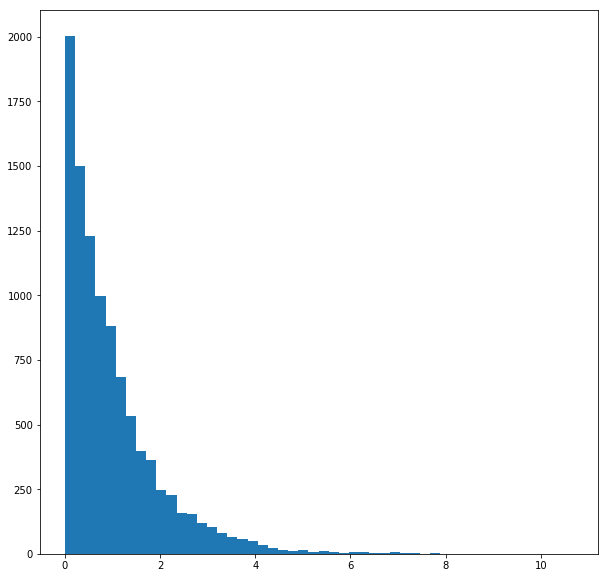

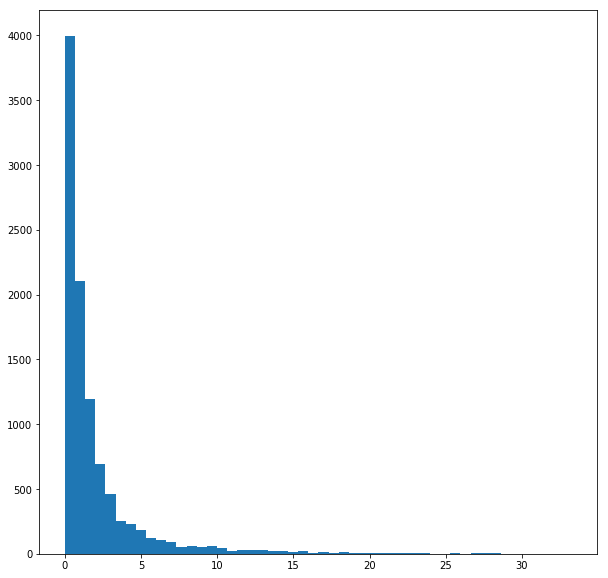

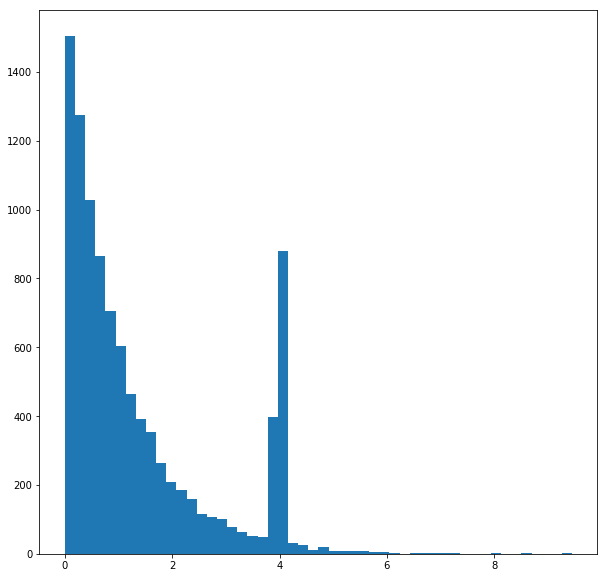

In [67]:
"""
Plot different distribution options
"""
import numpy as np
from matplotlib import pyplot as plt

samples = 10000
float_maker = 1000.

# exponential distribution
def server_time_exponential():
    server_time = np.random.exponential(1,1)
    return server_time

times = []
for n in range(samples):
    server_time = server_time_exponential()
    times.append(server_time[0])

print 'mean service time exponential =', np.mean(times)

plt.figure(figsize=(10,10))
plt.hist(times, 50)
plt.show

# longtail distribution
def server_time_longtail():
    random_number = np.random.random()
    if random_number > 1./4:
        server_time = np.random.exponential(1,1)
    if random_number <= 1./4:
        server_time = np.random.exponential(5,1)
    return server_time

times = []
for n in range(samples):
    server_time = server_time_longtail()
    times.append(server_time[0])

print 'mean service time long-tail =', np.mean(times)

plt.figure(figsize=(10,10))
plt.hist(times, 50)
plt.show

# bimodal distribution, with exponential and poisson turned into float
def server_time_longtail():
    random_number = np.random.random()
    if random_number > 1./8:
        server_time = np.random.exponential(1,1)
        server_time = server_time[0]
    if random_number <= 1./8:
        server_time = np.random.poisson(4*float_maker)/float_maker
    return server_time

times = []
for n in range(samples):
    server_time = server_time_longtail()
    times.append(server_time)

print 'mean service time bimodal =', np.mean(times)

plt.figure(figsize=(10,10))
plt.hist(times, 50)
plt.show

In [61]:
integerizer = 1000.
print np.random.poisson(5*integerizer)/integerizer


4.991
